In [177]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from filterpy.kalman import KalmanFilter
from sklearn.metrics import mean_squared_error

##### revisión de datos en crudo para verificar si necesitamos filtrar adicional

In [178]:
# Función para graficar datos
def plot_sensor_data(df, columns, title):
    plt.figure(figsize=(14, 7))
    for column in columns:
        plt.plot(df[column], label=column)
    plt.title(title)
    plt.xlabel('Índice')
    plt.ylabel('Valor')
    plt.legend()
    plt.show()

In [179]:
# Función para graficar histogramas
def plot_histogram(df, columns, title):
    plt.figure(figsize=(14, 7))
    for column in columns:
        plt.hist(df[column].dropna(), bins=50, alpha=0.5, label=column)
    plt.title(title)
    plt.xlabel('Valor')
    plt.ylabel('Frecuencia')
    plt.legend()
    plt.show()

In [180]:
# Función para graficar boxplots
def plot_boxplot(df, columns, title):
    plt.figure(figsize=(14, 7))
    df[columns].boxplot()
    plt.title(title)
    plt.ylabel('Valor')
    plt.xticks(range(1, len(columns) + 1), columns, rotation=45)
    plt.show()

In [181]:
# Ruta base donde están ubicadas las carpetas
ruta_base = r'C:\Users\Valentina\Documents\TESIS 1\captura 1 -20.08\datos vale xsens 20.08'

# Lista de nombres de carpetas
carpetas = ['lb gait fs 1', 'lb gait fs 2', 'lb gait ss 1', 'lb gait ss 2']

# Diccionario para almacenar los DataFrames
dataframes = {}

Revisión de datos para lb gait fs 1_muslo:
   SampleTimeFine    Quat_W    Quat_X    Quat_Y    Quat_Z      dq_W      dq_X  \
0      3166843622  0.369795  0.581618 -0.491902  0.531981  0.999958 -0.002954   
1      3166851955  0.368100  0.584402 -0.498101  0.524283  0.999946 -0.005070   
2      3166860288  0.367381  0.586230 -0.505297  0.515790  0.999936 -0.006913   
3      3166868621  0.368046  0.587179 -0.513161  0.506386  0.999924 -0.008850   
4      3166876954  0.369909  0.587516 -0.521192  0.496338  0.999915 -0.010195   

       dq_Y      dq_Z     dv[1]  ...     Acc_X     Acc_Y     Acc_Z  \
0 -0.008701 -0.000309  0.067542  ...  8.113680 -0.192472  0.901199   
1 -0.009081  0.000302  0.068024  ...  8.169252  0.333989  0.609737   
2 -0.008923  0.000552  0.068440  ...  8.212389 -0.087545 -0.128708   
3 -0.008551  0.000344  0.070576  ...  8.460885 -1.126238 -1.005382   
4 -0.008065 -0.000092  0.074746  ...  8.956229 -2.122121 -1.777947   

        Gyr_X       Gyr_Y     Gyr_Z     Mag_X    

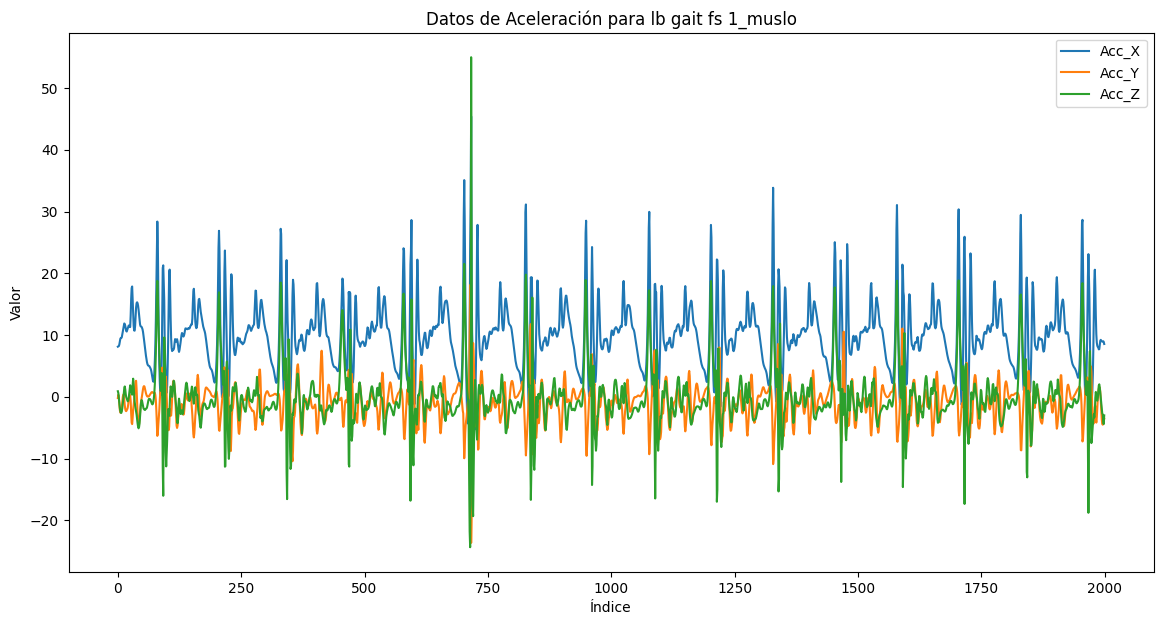

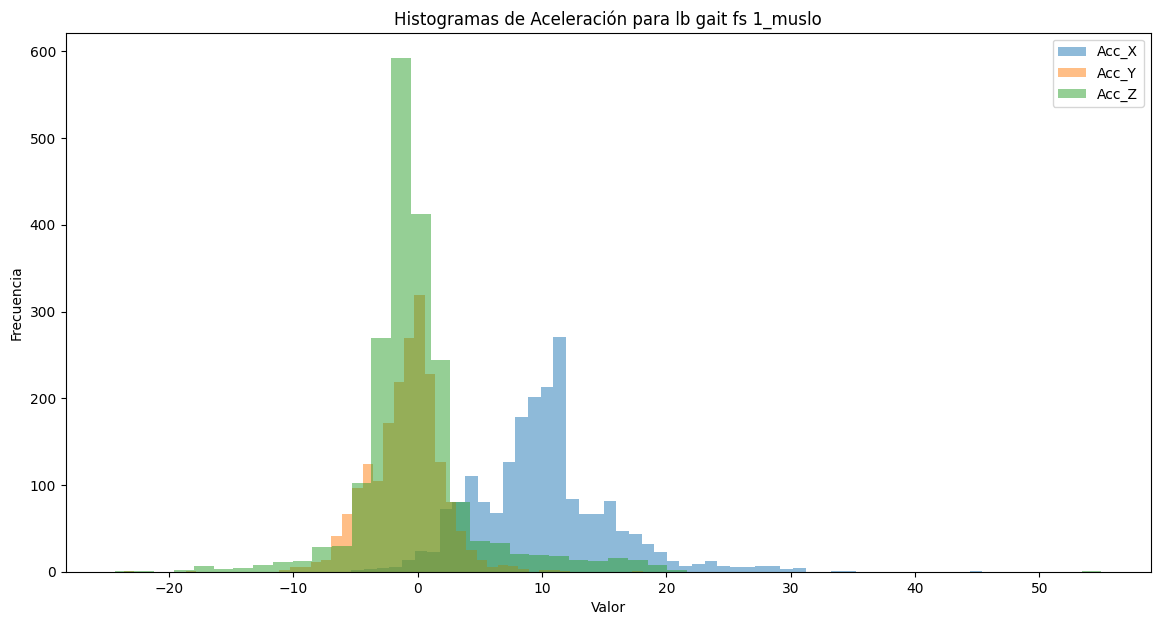

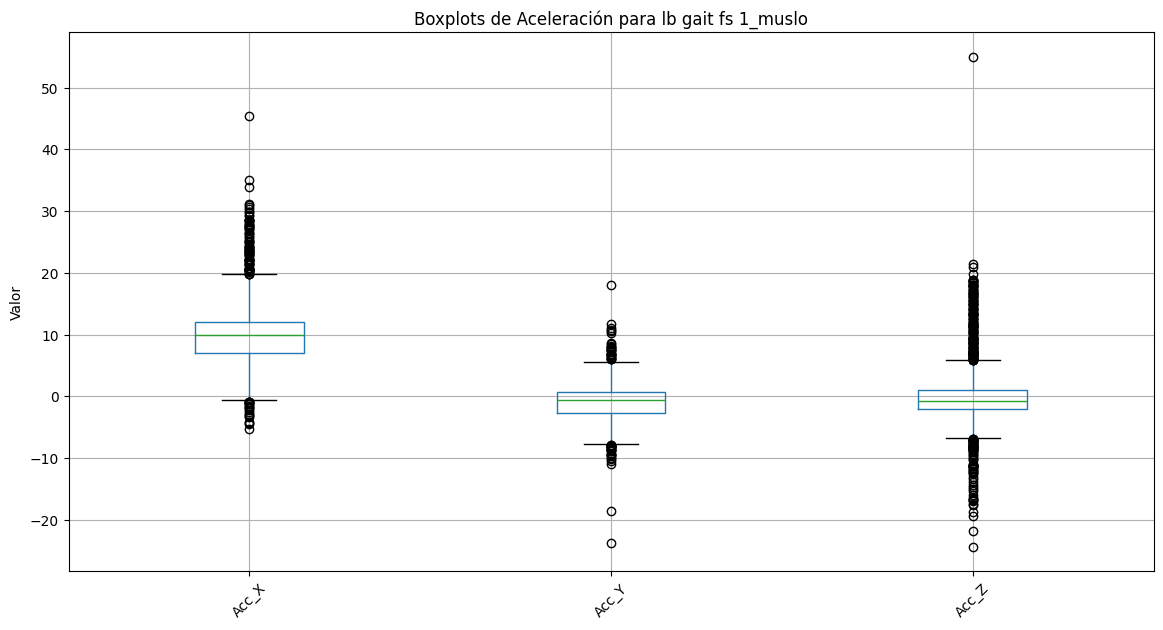

In [182]:
# Contador para limitar a tres archivos
file_counter = 0
max_files = 1

# Iterar sobre cada carpeta
for carpeta in carpetas:
    ruta_carpeta = os.path.join(ruta_base, carpeta)
    
    # Iterar sobre cada archivo en la carpeta
    for archivo in os.listdir(ruta_carpeta):
        if archivo.endswith('.csv') and file_counter < max_files:
            # Crear la ruta completa del archivo
            ruta_archivo = os.path.join(ruta_carpeta, archivo)
            
            # Leer el archivo CSV en un DataFrame
            df = pd.read_csv(ruta_archivo)
            
            # Eliminar las columnas no deseadas
            columnas_a_eliminar = ['PacketCounter', 'Status']
            df = df.drop(columns=columnas_a_eliminar, errors='ignore')
            
            # Filtrar datos a partir del índice 2000
            df = df.iloc[3000:5000].reset_index(drop=True)
            
            # Guardar el DataFrame en el diccionario usando un identificador
            identificador = f"{carpeta}_{archivo.split('_')[0]}"
            dataframes[identificador] = df
            
            # Revisión de Datos en Crudo
            print(f"Revisión de datos para {identificador}:")
            print(df.head())
            print(df.info())
            print(df.describe())
            
            # Seleccionar las tres columnas a graficar
            columnas_a_graficar = ['Acc_X', 'Acc_Y', 'Acc_Z']  # Reemplaza con las columnas de interés

            # Graficar los datos seleccionados
            plot_sensor_data(df, columnas_a_graficar, f'Datos de Aceleración para {identificador}')
            plot_histogram(df, columnas_a_graficar, f'Histogramas de Aceleración para {identificador}')
            plot_boxplot(df, columnas_a_graficar, f'Boxplots de Aceleración para {identificador}')
            
            # Incrementar el contador de archivos procesados
            file_counter += 1

        # Terminar el proceso después de procesar tres archivos
        if file_counter >= max_files:
            break
    if file_counter >= max_files:
        break

##### Nos damos cuenta que aunque filtra los puntos y ajusta los valores, debemos usar filtrado por ventaneo para eliminar frecuencias inexactas y discrepantes, se procede

In [183]:
# Función para ventaneo de datos
def windowing(data, window_size, step_size):
    windows = []
    for start in range(0, len(data) - window_size + 1, step_size):
        end = start + window_size
        windows.append(data.iloc[start:end].reset_index(drop=True))
    return windows

In [184]:
# Función para filtro de media móvil
def moving_average(data, window_size):
    return data.rolling(window=window_size).mean()

In [185]:
# Función para filtro de Kalman
def kalman_filter(data, process_var, measurement_var):
    kf = KalmanFilter(dim_x=4, dim_z=1)
    kf.x = np.array([0., 0., 0., 0.])  # Estado inicial
    kf.P *= 1000.  # Incertidumbre inicial
    kf.F = np.eye(4)  # Matriz de transición de estado
    kf.H = np.array([[1., 0., 0., 0.]])  # Matriz de observación
    kf.R = measurement_var  # Varianza de medición
    kf.Q = process_var * np.eye(4)  # Varianza de proceso
    
    filtered_data = []
    for measurement in data:
        kf.predict()
        kf.update(measurement)
        filtered_data.append(kf.x[0])
    return np.array(filtered_data)

In [186]:
def mahony_filter(acc, gyro, Kp=0, Ki=10000, dt=0.01):
    """
    Implementa el filtro de Mahony para la estimación de orientación.
    - acc: Aceleraciones (array de tamaño [N, 3]).
    - gyro: Velocidades angulares (array de tamaño [N, 3]).
    - Kp: Ganancia proporcional.
    - Ki: Ganancia integral.
    - dt: Intervalo de tiempo.
    """
    
    q = np.array([1.0, 0.0, 0.0, 0.0])  # Cuaternión inicial
    integral_fb = np.array([0.0, 0.0, 0.0])
    orientation = []

    for i in range(len(acc)):
        acc_norm = acc[i] / np.linalg.norm(acc[i])  # Normaliza el vector de aceleración porque no estaban normalizados ni el gyr
        gyro_norm = gyro[i] * np.pi / 180.0  # Convierte la velocidad angular a radianes por segundo
        
        # Estimación de la gravedad en el marco de referencia de la tierra, se calcula la orientación actual estimada usando los quaterniones.
        v = np.array([2*(q[1]*q[3] - q[0]*q[2]), 
                      2*(q[0]*q[1] + q[2]*q[3]), 
                      q[0]**2 - q[1]**2 - q[2]**2 + q[3]**2])
        
        # Calcular el error (producto cruzado entre la estimación y la medición real)
        error = np.cross(v, acc_norm)
        integral_fb += Ki * error * dt  # Parte integral
        gyro_corrected = gyro_norm + Kp * error + integral_fb  # Ajuste del giroscopio
        
        # Integrar la velocidad angular ajustada para obtener la nueva orientación
        q_dot = 0.5 * np.array([
            -q[1]*gyro_corrected[0] - q[2]*gyro_corrected[1] - q[3]*gyro_corrected[2],
             q[0]*gyro_corrected[0] + q[2]*gyro_corrected[2] - q[3]*gyro_corrected[1],
             q[0]*gyro_corrected[1] - q[1]*gyro_corrected[2] + q[3]*gyro_corrected[0],
             q[0]*gyro_corrected[2] + q[1]*gyro_corrected[1] - q[2]*gyro_corrected[0]
        ])
        
        q += q_dot * dt
        q /= np.linalg.norm(q)  # Normalizar el cuaternión
        orientation.append(q.copy())
    
    return np.array(orientation)


In [187]:
# Parámetros ajustados para filtro de Kalman
process_var = 1e-4  # Aumentado
measurement_var = 1e-2  # Reducido

# Contador para limitar a los mismos tres archivos
file_counter = 0
max_files = 1


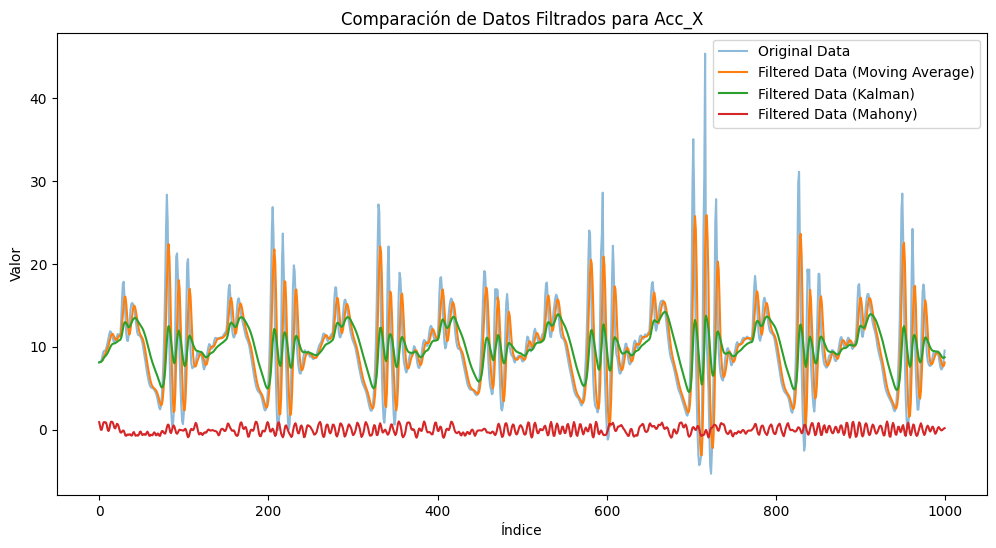

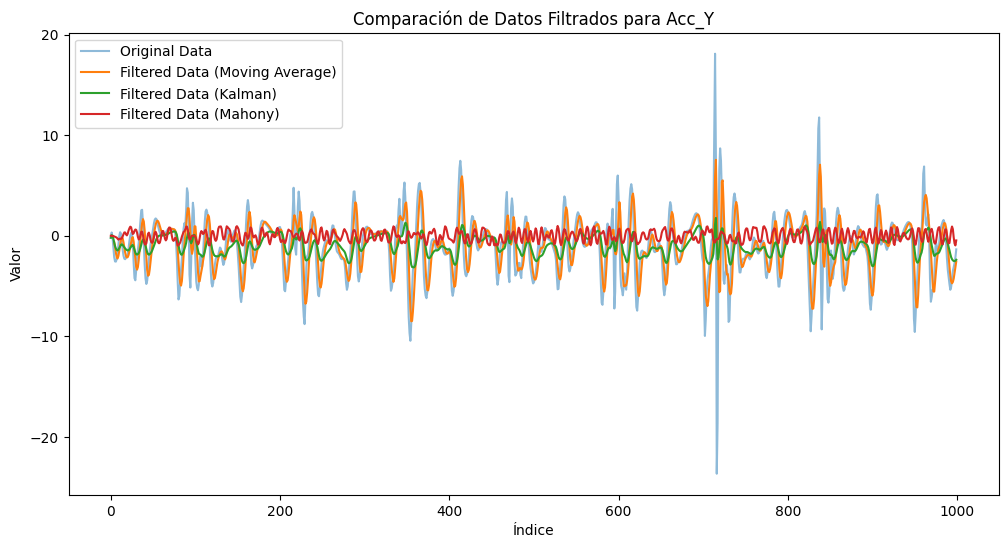

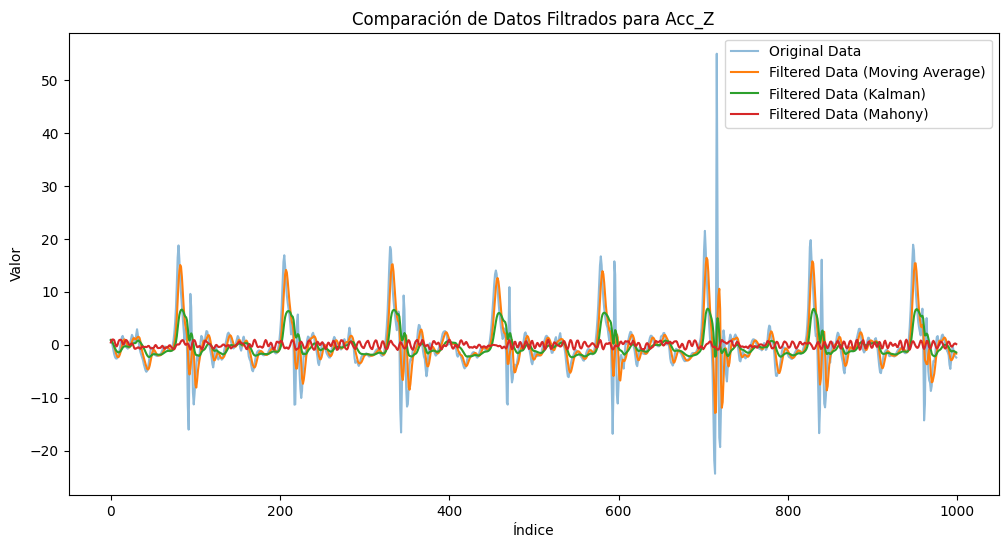

In [188]:
# Iterar sobre cada carpeta
for carpeta in carpetas:
    ruta_carpeta = os.path.join(ruta_base, carpeta)
    
    # Iterar sobre cada archivo en la carpeta
    for archivo in os.listdir(ruta_carpeta):
        if archivo.endswith('.csv') and file_counter < max_files:
            # Crear la ruta completa del archivo
            ruta_archivo = os.path.join(ruta_carpeta, archivo)
            
            # Leer el archivo CSV en un DataFrame
            df = pd.read_csv(ruta_archivo)
            
            # Eliminar las columnas no deseadas
            columnas_a_eliminar = ['PacketCounter', 'Status']
            df = df.drop(columns=columnas_a_eliminar, errors='ignore')
            
            # Filtrar datos del índice 3000 al 5000
            df = df.iloc[3000:4000].reset_index(drop=True)
            
            # Aplicar filtro de media móvil
            df['Acc_X_filtered'] = moving_average(df['Acc_X'], window_size=5)
            df['Acc_Y_filtered'] = moving_average(df['Acc_Y'], window_size=5)
            df['Acc_Z_filtered'] = moving_average(df['Acc_Z'], window_size=5)
            
            # Aplicar filtro de Kalman ajustado
            df['Acc_X_kalman'] = kalman_filter(df['Acc_X'], process_var, measurement_var)
            df['Acc_Y_kalman'] = kalman_filter(df['Acc_Y'], process_var, measurement_var)
            df['Acc_Z_kalman'] = kalman_filter(df['Acc_Z'], process_var, measurement_var)
            
            # Aplicar filtro de Mahony (el eje Z se mantiene constante)
            df['Acc_X_mahony'] = mahony_filter(df[['Acc_X', 'Acc_Y', 'Acc_Z']].values, df[['Gyr_X', 'Gyr_Y', 'Gyr_Z']].values)[:, 0]
            df['Acc_Y_mahony'] = mahony_filter(df[['Acc_X', 'Acc_Y', 'Acc_Z']].values, df[['Gyr_X', 'Gyr_Y', 'Gyr_Z']].values)[:, 1]
            df['Acc_Z_mahony'] = mahony_filter(df[['Acc_X', 'Acc_Y', 'Acc_Z']].values, df[['Gyr_X', 'Gyr_Y', 'Gyr_Z']].values)[:, 2]
                        
            # Graficar comparación de datos filtrados y originales
            for axis in ['X', 'Y', 'Z']:
                plt.figure(figsize=(12, 6))
                plt.plot(df[f'Acc_{axis}'], label='Original Data', alpha=0.5)
                plt.plot(df[f'Acc_{axis}_filtered'], label='Filtered Data (Moving Average)')
                plt.plot(df[f'Acc_{axis}_kalman'], label='Filtered Data (Kalman)')
                plt.plot(df[f'Acc_{axis}_mahony'], label='Filtered Data (Mahony)')
                plt.title(f'Comparación de Datos Filtrados para Acc_{axis}')
                plt.xlabel('Índice')
                plt.ylabel('Valor')
                plt.legend()
                plt.show()
            
            # Incrementar el contador de archivos procesados
            file_counter += 1

        # Terminar el proceso después de procesar tres archivos
        if file_counter >= max_files:
            break
    if file_counter >= max_files:
        break

In [189]:
#### ESTO CON SOLO MEDIA MÓVIL Y KALMAN

for carpeta in carpetas:
    ruta_carpeta = os.path.join(ruta_base, carpeta)
    
    # Iterar sobre cada archivo en la carpeta
    for archivo in os.listdir(ruta_carpeta):
        if archivo.endswith('.csv') and file_counter < max_files:
            # Crear la ruta completa del archivo
            ruta_archivo = os.path.join(ruta_carpeta, archivo)
            
            # Leer el archivo CSV en un DataFrame
            df = pd.read_csv(ruta_archivo)
            
            # Eliminar las columnas no deseadas
            columnas_a_eliminar = ['PacketCounter', 'Status']
            df = df.drop(columns=columnas_a_eliminar, errors='ignore')
            
            # Filtrar datos del índice 3000 al 5000
            df = df.iloc[3000:5000].reset_index(drop=True)
            
            # Aplicar filtro de media móvil
            df['Acc_X_filtered'] = moving_average(df['Acc_X'], window_size=5)
            df['Acc_Y_filtered'] = moving_average(df['Acc_Y'], window_size=5)
            df['Acc_Z_filtered'] = moving_average(df['Acc_Z'], window_size=5)
            
            # Aplicar filtro de Kalman
            df['Acc_X_kalman'] = kalman_filter(df['Acc_X'], process_var, measurement_var)
            df['Acc_Y_kalman'] = kalman_filter(df['Acc_Y'], process_var, measurement_var)
            df['Acc_Z_kalman'] = kalman_filter(df['Acc_Z'], process_var, measurement_var)
            
            # Verificar nombres de columnas disponibles
            print(f"Columnas disponibles para {identificador}: {df.columns.tolist()}")
            
            # Graficar solo datos filtrados
            for axis in ['X', 'Y', 'Z']:
                if f'Acc_{axis}_filtered' in df.columns and f'Acc_{axis}_kalman' in df.columns:
                    plt.figure(figsize=(12, 6))
                    plt.plot(df[f'Acc_{axis}'], label='Original Data', alpha=0.5)
                    plt.plot(df[f'Acc_{axis}_filtered'], label='Filtered Data (Moving Average)')
                    plt.plot(df[f'Acc_{axis}_kalman'], label='Filtered Data (Kalman)')
                    plt.title(f'Datos Filtrados para Acc_{axis}')
                    plt.xlabel('Índice')
                    plt.ylabel('Valor')
                    plt.legend()
                    plt.show()
                else:
                    print(f"Faltan columnas filtradas para Acc_{axis} en {identificador}")
            
            # Incrementar el contador de archivos procesados
            file_counter += 1

        # Terminar el proceso después de procesar tres archivos
        if file_counter >= max_files:
            break
    if file_counter >= max_files:
        break


In [190]:
print(dataframes.keys())

dict_keys(['lb gait fs 1_muslo'])


In [191]:
# Acceder al DataFrame correspondiente al muslo en la carpeta 'lb gait fs 1'
df_muslo = dataframes['lb gait fs 1_muslo']
print(df_muslo.head())

   SampleTimeFine    Quat_W    Quat_X    Quat_Y    Quat_Z      dq_W      dq_X  \
0      3166843622  0.369795  0.581618 -0.491902  0.531981  0.999958 -0.002954   
1      3166851955  0.368100  0.584402 -0.498101  0.524283  0.999946 -0.005070   
2      3166860288  0.367381  0.586230 -0.505297  0.515790  0.999936 -0.006913   
3      3166868621  0.368046  0.587179 -0.513161  0.506386  0.999924 -0.008850   
4      3166876954  0.369909  0.587516 -0.521192  0.496338  0.999915 -0.010195   

       dq_Y      dq_Z     dv[1]  ...     Acc_X     Acc_Y     Acc_Z  \
0 -0.008701 -0.000309  0.067542  ...  8.113680 -0.192472  0.901199   
1 -0.009081  0.000302  0.068024  ...  8.169252  0.333989  0.609737   
2 -0.008923  0.000552  0.068440  ...  8.212389 -0.087545 -0.128708   
3 -0.008551  0.000344  0.070576  ...  8.460885 -1.126238 -1.005382   
4 -0.008065 -0.000092  0.074746  ...  8.956229 -2.122121 -1.777947   

        Gyr_X       Gyr_Y     Gyr_Z     Mag_X     Mag_Y     Mag_Z  Unnamed: 23  
0  -40.6284